# 🦆 DuckDetector: A Project for Automatically Detecting Ducks 🦆
This notebook covers training the YOLOv8 Object Detection Models which will be deployed on various user interfaces.

**Author:** [Timothy Do](https://timothydo.me)

<a href="https://colab.research.google.com/github/dotimothy/DuckDetector/blob/model/TrainDuckDetector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup
This section checks the adequate preqrequisites are installed in the Python environment and also install additional dependencies depending if the user is running Google CoLab or not.

In [1]:
# Check if Environment is in Google CoLab:
IN_COLAB = True
try:
    import google.colab
except:
    IN_COLAB = False

In [2]:
if(IN_COLAB):
    !curl https://raw.githubusercontent.com/dotimothy/DuckDetector/model/requirements.txt -o ./requirements.txt
!pip install -r requirements.txt


[notice] A new release of pip available: 22.2.1 -> 24.2
[notice] To update, run: C:\Users\Timothy Do\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [3]:
# Importing Libraries
import os
import torch
import cv2 as cv
import numpy as np
import cpuinfo
import psutil
import ultralytics
import pandas as pd
from tqdm import tqdm 
import random
from openimages.download import download_dataset
import matplotlib.pyplot as plt
import re

# For Printing Purposes
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

To adequately train the DuckDetector, make sure a GPU is detected in the runtime. GPU accelerates the developnment of AI models by parallelizing matrix multiplication and convolution operations that are nececssary to accelerate gradient backpropogation for effcient learning. 

In [4]:
# Environment Specifications
print(f'{color.BOLD}***** Environment Specifications *****{color.END}')
print(f"{color.BOLD}In CoLab{color.END}: {IN_COLAB}\n")

# Device to Develop PyTorch Models On
use_cuda = torch.cuda.is_available()
use_mps = torch.backends.mps.is_available()
device = torch.device('cuda' if use_cuda else ('mps' if use_mps else 'cpu'))
print(f'{color.BOLD}CPU:{color.END} {cpuinfo.get_cpu_info()["brand_raw"]}')
print(f'\t- {color.BOLD}# CPU Cores:{color.END} {psutil.cpu_count(logical=False)}')
print(f'\t- {color.BOLD}# CPU Threads:{color.END} {psutil.cpu_count(logical=True)}')
print(f'\t- {color.BOLD}Total System RAM:{color.END} {psutil.virtual_memory().total/(1024**3):.1f} GB ')
print(f'\n{color.BOLD}GPU:{color.END} {torch.cuda.get_device_name(device) if use_cuda else None}')
if(use_cuda):
    print(f'\t- {color.BOLD}Total GPU VRAM:{color.END} {torch.cuda.get_device_properties(device).total_memory/(1024**3):.1f} GB\n')
    !nvidia-smi

***** Environment Specifications *****
In CoLab: False

CPU: Intel(R) Core(TM) i9-9900K CPU @ 3.60GHz
	- # CPU Cores: 8
	- # CPU Threads: 16
	- Total System RAM: 63.9 GB 

GPU: NVIDIA GeForce RTX 3060
	- Total GPU VRAM: 12.0 GB

Wed Aug  7 23:05:22 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 531.18                 Driver Version: 531.18       CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                      TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3060       WDDM | 00000000:01:00.0  On |                  N/A |
|  0%   54C    P8  

## Dataset Preprocessing
This section covers how to download various datasets and unify them under a common standard for training the duck detection models. The [spreadsheet](https://docs.google.com/spreadsheets/d/1AfuZ8lFaX3Iy5eNDXTxvasOeE4mqal2Pe8c--oDRmOg/edit?usp=sharing) of each individual dataset viewable in the cell below:

In [5]:
dataset_df = pd.read_csv('https://docs.google.com/spreadsheets/d/1AfuZ8lFaX3Iy5eNDXTxvasOeE4mqal2Pe8c--oDRmOg/export?format=csv')
display(dataset_df)

,Name,# of Images,Original Source,ImagesCV,Include Cartoon,Link
0,OpenImages (Duck),1289,Open Images Dataset V7,No,No,https://storage.googleapis.com/openimages/web/...
1,OpenImages (Goose),577,Open Images Dataset V7,No,No,https://storage.googleapis.com/openimages/web/...
2,Wood Duck,216,300 Bird Species Classification,Yes,No,https://images.cv/dataset/wood-duck-image-clas...
3,Teal Duck,167,300 Bird Species Classifcation,Yes,No,https://images.cv/dataset/teal-duck-image-clas...
4,Steamer Duck,122,300 Bird Species Classification,Yes,No,https://images.cv/dataset/steamer-duck-image-c...
5,Red Headed Duck,127,300 Bird Species Classification,Yes,No,https://images.cv/dataset/red-headed-duck-imag...
6,Mandrin Duck,134,300 Bird Species Classification,Yes,No,https://images.cv/dataset/mandrin-duck-image-c...
7,Mallard Duck,140,300 Bird Species Classification,Yes,No,https://images.cv/dataset/mallard-duck-image-c...
8,Duck,1000,Domainnet,Yes,Yes,https://images.cv/dataset/duck-image-classific...
9,Drake,1300,Imagenet Object Localization,Yes,No,https://images.cv/dataset/drake-image-classifi...


### OpenImages
This section will overview Google's already annotated image sets for the **Duck** and the **Goose** from their [Openimages](https://storage.googleapis.com/openimages/web/index.html) dataset. Each subset has the following amount of images:

**Duck**
- Train: 1151 Images
- Validation: 37 Images
- Test: 101 Images
- **Total:** 1289 Images

**Goose**
- Train: 518 Images
- Validation: 16 Images
- Test: 43 Images
- **Total:** 577 Images 

It is to be noted that the *openimages* API merges the train/val/test subsets all into a single collection (i.e., all images are merged into a single folder, anonymizing which subset each one was in).

In [6]:
# Downloading the OpenImages Subset of Duck and Goose 
dataPath = './data/'
openPath = f'{dataPath}/OpenImages/'
duckPath = f'{openPath}/duck/'
goosePath = f'{openPath}/goose/'
if(not(os.path.exists(dataPath))): # Making OpenImages Directory
    os.mkdir(dataPath)
if(not(os.path.exists(openPath))): # Making OpenImages Directory
    os.mkdir(openPath)
if(not(os.path.exists(duckPath))): # Downloading Duck Subset
    print(f'***** Downloading {color.BOLD}OpenImages Duck{color.END} Dataset!*****')
    download_dataset(openPath,['Duck',],annotation_format='darknet') 
if(not(os.path.exists(goosePath))): # Downloading Duck Subset
    print(f'\n***** Downloading {color.BOLD}OpenImages Goose{color.END} Dataset! *****')
    download_dataset(openPath,['Goose',],annotation_format='darknet') 

***** Downloading OpenImages Duck Dataset!*****


2024-08-07  23:06:08 INFO Downloading 1151 train images for class 'duck'
100%|██████████| 1151/1151 [00:34<00:00, 33.84it/s]
2024-08-07  23:06:42 INFO Creating 1151 train annotations (darknet) for class 'duck'
100%|██████████| 1151/1151 [00:02<00:00, 543.13it/s] 
2024-08-07  23:06:47 INFO Downloading 37 validation images for class 'duck'
100%|██████████| 37/37 [00:02<00:00, 16.74it/s]
2024-08-07  23:06:49 INFO Creating 37 validation annotations (darknet) for class 'duck'
100%|██████████| 37/37 [00:01<00:00, 26.67it/s]
2024-08-07  23:06:54 INFO Downloading 101 test images for class 'duck'
100%|██████████| 101/101 [00:03<00:00, 27.46it/s]
2024-08-07  23:06:58 INFO Creating 101 test annotations (darknet) for class 'duck'
100%|██████████| 101/101 [00:01<00:00, 72.53it/s]



***** Downloading OpenImages Goose Dataset! *****


2024-08-07  23:07:45 INFO Downloading 518 train images for class 'goose'
100%|██████████| 518/518 [00:15<00:00, 33.38it/s]
2024-08-07  23:08:00 INFO Creating 518 train annotations (darknet) for class 'goose'
100%|██████████| 518/518 [00:01<00:00, 326.35it/s]
2024-08-07  23:08:04 INFO Downloading 16 validation images for class 'goose'
100%|██████████| 16/16 [00:01<00:00, 15.57it/s]
2024-08-07  23:08:05 INFO Creating 16 validation annotations (darknet) for class 'goose'
100%|██████████| 16/16 [00:01<00:00, 11.73it/s]
2024-08-07  23:08:09 INFO Downloading 43 test images for class 'goose'
100%|██████████| 43/43 [00:01<00:00, 25.37it/s]
2024-08-07  23:08:11 INFO Creating 43 test annotations (darknet) for class 'goose'
100%|██████████| 43/43 [00:01<00:00, 30.81it/s]


Now that **Duck** and **Goose** sets from OpenImages have been downloaded, let's visualize a few of the duck images and their corresponding bounding box coordinates created by humans! The format of the each YOLO bounding box coordinate label is as the following:

*class* *x_center* *y_center* *width* *height*

where the center coordinates (i.e., the upper left of the box), width, and height are normalized from 0 to 1. For initial visualization, bounding boxes are drawn onto a random image on the **Duck** set.


Test Duck Image


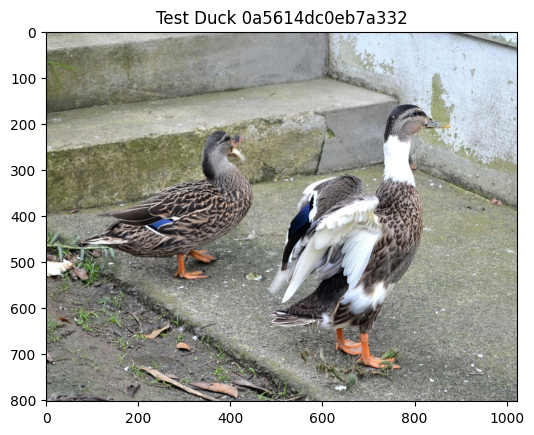

Test Duck (0a5614dc0eb7a332) Image Labels
0 0.255625 0.4645135 0.36750000000000005 0.401117
0 0.655625 0.5482454999999999 0.41625 0.7153109999999999


In [7]:
# Helper Function to Draw Bounding Boxes
def drawBoundingBox(image,label): # Assume a Single Object Class
    h,w,c = image.shape
    xNorm,yNorm,bw,bh = [float(res) for res in re.findall("\d+\.\d+",label)]
    image = cv.rectangle(image,(int(w*(xNorm-0.5*bw)),int(h*(yNorm-0.5*bh))),(int(w*(xNorm+0.5*bw)),int(h*(yNorm+0.5*bh))),(255,0,0),3)
    return image

# Reading an Example Image from Duck Set
img_prefixes = [os.path.split(img)[1].split('.')[0] for img in os.listdir(f'{duckPath}/images/')]
img_prefix = random.choice(img_prefixes)
test_img = plt.imread(f'{duckPath}/images/{img_prefix}.jpg')
print(f'{color.BOLD}Test Duck Image{color.END}')
plt.figure()
plt.imshow(test_img)
plt.title(f'Test Duck {img_prefix}')
plt.show()

# Reading Bounding Box Labels for the Example Duck  Image
print(f'{color.BOLD}Test Duck ({img_prefix}) Image Labels{color.END}')
test_labels = open(f'{duckPath}/darknet/{img_prefix}.txt',newline='')
for label in test_labels.readlines():
    print(label,end='')
test_labels.close()

Let's make sense of the bounding box labels and visualize them by drawing the manually annotated bounding boxes to the image!

Test Duck 0a5614dc0eb7a332 with Bounded Box Label


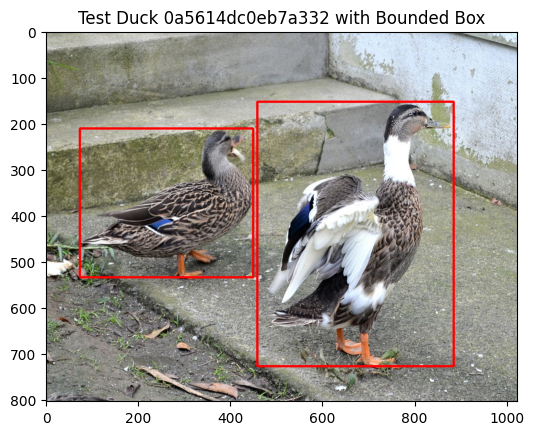

In [8]:
# Reading Test Duck Labels
test_label = open(f'{duckPath}/darknet/{img_prefix}.txt',newline='')
test_img_bounded = test_img.copy()
for label in test_label.readlines():
    test_img_bounded = drawBoundingBox(test_img_bounded,label)

# Displaying Bounded Box over the Duck Image
print(f'{color.BOLD}Test Duck {img_prefix} with Bounded Box Label{color.END}')
plt.figure()
plt.imshow(test_img_bounded)
plt.title(f'Test Duck {img_prefix} with Bounded Box')
plt.show()

Let's try the same bounding box visualization on the **Goose** subset.

Test Goose Image


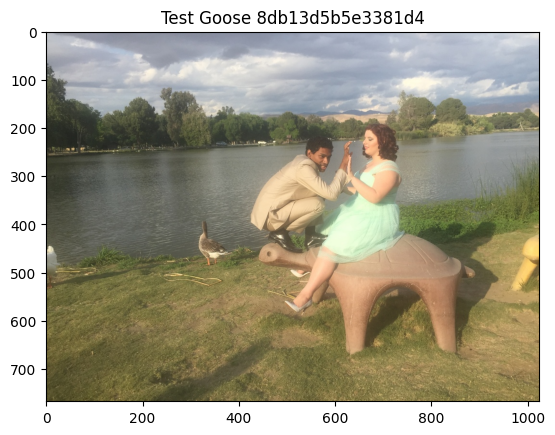

Test Goose (8db13d5b5e3381d4) Image Labels
0 0.339375 0.56875 0.0675 0.125834

Test Goose 8db13d5b5e3381d4 with Bounded Box Label


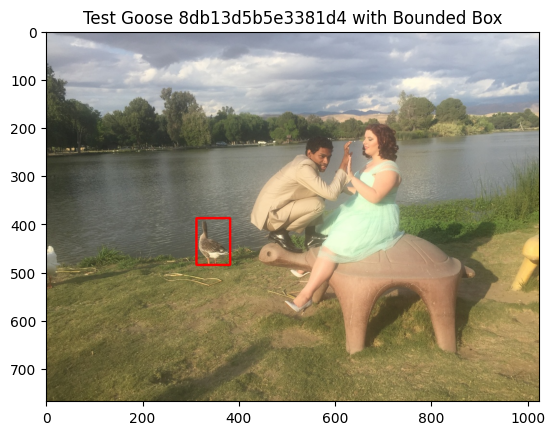

In [9]:
# Reading an Example Image from Goose Set
img_prefixes = [os.path.split(img)[1].split('.')[0] for img in os.listdir(f'{goosePath}/images/')]
img_prefix = random.choice(img_prefixes)
test_img = plt.imread(f'{goosePath}/images/{img_prefix}.jpg')
print(f'{color.BOLD}Test Goose Image{color.END}')
plt.figure()
plt.imshow(test_img)
plt.title(f'Test Goose {img_prefix}')
plt.show()

# Reading Bounding Box Labels for the Example Goose Image
print(f'{color.BOLD}Test Goose ({img_prefix}) Image Labels{color.END}')
test_labels = open(f'{goosePath}/darknet/{img_prefix}.txt',newline='')
test_img_bounded = test_img.copy()
for label in test_labels.readlines():
    test_img_bounded = drawBoundingBox(test_img_bounded,label)
    print(label,end='')
test_labels.close()

# Displaying Bounded Box over the Goose Image
print(f'\n{color.BOLD}Test Goose {img_prefix} with Bounded Box Label{color.END}')
plt.figure()
plt.imshow(test_img_bounded)
plt.title(f'Test Goose {img_prefix} with Bounded Box')
plt.show()

## Train an Initial Object Detection Model with YOLOv8
This section covers how to train an initial YOLOv8 model with the Openimages Duck/Goose Dataset.